In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# from src.models import *
from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

# Load test data

In [3]:
ds_test = pickle.load(open("/datadrive_ssd/saved_datasets/testdataset_ensemble_forecast_x10_log_trans_first_days_2.pkl", "rb"))

sampler_test = torch.utils.data.SequentialSampler(ds_test)

dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=64, sampler=sampler_test
)

# Load model

In [4]:
gan = WGANGP.load_from_checkpoint("../ilan/models/wgan-gp/1/epoch=124-step=334999.ckpt")
gen = gan.gen
gen = gen.to(device)
gen.train(False);

### Sanity check plots

In [5]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3]).to(device)
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 1, 3, 3], but got 5-dimensional input of size [64, 1, 10, 16, 16] instead

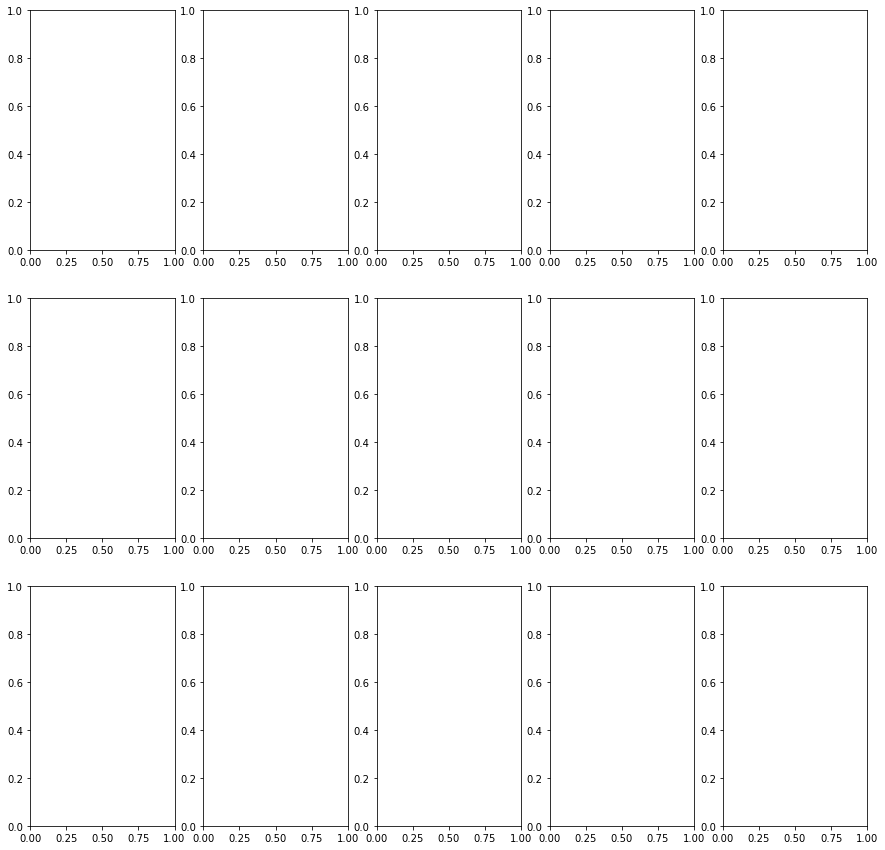

In [6]:
x_sample, y_sample = next(iter(dl_test))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
plot_samples_per_input(x_sample, y_sample, gen, k=3)

# Eval Model

## Evaluation

In [7]:
num_samples = 1

### By Patch

In [8]:
patch_crps, patch_rmse = gen_patch_eval(gen, dl_test, num_samples, ds_test.mins.tp.values, ds_test.maxs.tp.values, ds_test.tp_log, device)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 1, 3, 3], but got 5-dimensional input of size [64, 1, 10, 16, 16] instead

In [9]:
print(patch_crps)

NameError: name 'patch_crps' is not defined

In [11]:
print(patch_rmse)

0.98464406


### By full map

In [12]:
# get full map ground truth
mrms = get_full_masked_mrms(gen, ds_test, device)

preds, full_crps, full_rmse = gen_full_eval(gen, ds_test, mrms, num_samples, device)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [13]:
print(full_crps)

0.4109141459328723


In [14]:
print(full_rmse)

1.9883680611696497


In [16]:
mrms_pert = mrms + np.random.normal(scale=1e-6, size=mrms.shape)

preds_pert = preds + np.random.normal(scale=1e-6, size = preds.shape)

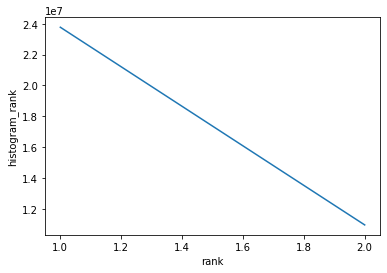

In [28]:
xs.rank_histogram(mrms_pert.chunk({'valid_time': 1}), preds_pert.chunk({'valid_time': 1, 'member':2})).compute().plot()

## Interpolation baseline

In [25]:
tigge, interp, interp_rmse = interpolation_full_baseline(ds_test, mrms)

In [26]:
print(interp_rmse)

2.1790555709244024


In [22]:
interp_pert = interp + np.random.normal(scale=1e-6, size=interp.shape)

In [24]:
interp_pert

<xarray.DataArray (valid_time: 44, lat: 744, lon: 1376)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
          2.84507723e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
          2.90193245e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
          2.95880685e-01,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [            nan,             nan,             nan, ...,
          5.61914820e-07,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -1.14396311e-06,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -3.98109795e-07,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
          1.02404302e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
          1.20942816e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
          1.39481692e-01,             nan,             nan]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [23]:
xs.rank_histogram(mrms_pert.chunk({'valid_time': 1}), interp_pert.chunk({'valid_time': 1})).compute().plot()

ValueError: operand to apply_ufunc has required core dimensions ['member'], but some of these dimensions are absent on an input variable: ['member']

## Rank Historgrams

In [ ]:
mrms_pert = mrms + np.random.normal(scale=1e-6, size=mrms.shape)
interp_pert = interp + np.random.normal(scale=1e-6, size=interp.shape)

# Visulising full map

In [16]:
eval_mask = make_eval_mask()

In [20]:
valid_time = 10

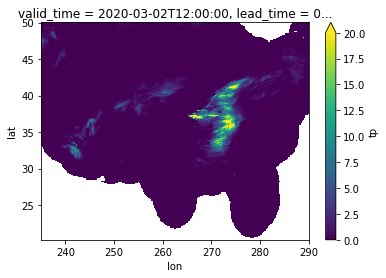

In [21]:
mrms.isel(valid_time=valid_time).plot(vmin=0, vmax=20)

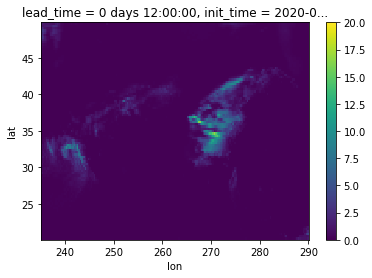

In [25]:
tigge.isel(valid_time=valid_time).plot(vmin=0, vmax=20)

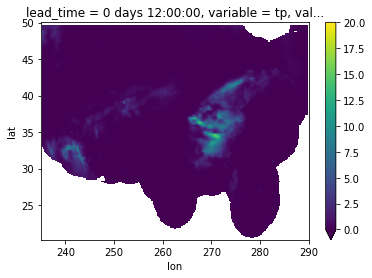

In [27]:
interp.where(eval_mask).isel(valid_time=valid_time).plot(vmin=0, vmax=20)

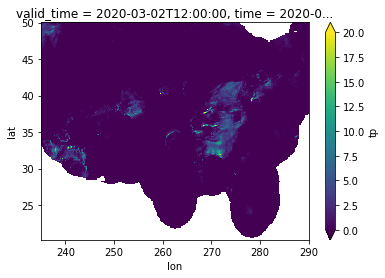

In [28]:
for i in range(1):
    plt.figure()
    preds.where(eval_mask).isel(valid_time = valid_time, member=i).plot(vmin=0, vmax=20)